In [41]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("../../")

import os
print(os.getcwd())

import tempfile
from pathlib import Path
import numpy as np
from torch.utils.data import DataLoader
from models.basic import CNN, BidirectionalRNN
from torch import nn
from loss_module.stroke_recovery_loss import StrokeLoss
import torch
from models.CoordConv import CoordConv
from trainers import TrainerStrokeRecovery
from hwr_utils.stroke_dataset import StrokeRecoveryDataset, read_img
from hwr_utils.stroke_recovery import *
from hwr_utils import utils, stroke_recovery
from torch.optim import lr_scheduler
from timeit import default_timer as timer
from train_stroke_recovery import graph


/media/data/GitHub/simple_hwr/hwr_utils/testing
../../data/online_coordinate_data/MAX_stroke_vTEST_AUGMENTFull/test_online_coords.json


INFO:root.hwr_utils.stroke_dataset:('Original dataloader size', 501)
INFO:root.hwr_utils.stroke_dataset:('Dataloader size', 5)
100%|██████████| 5/5 [00:00<00:00, 1211.11it/s]


In [50]:
from time import sleep
device="cuda"
example = next(iter(test_dataloader)) # BATCH, WIDTH, VOCAB
output = Path("./TEST_GRAPHING")
print(example.keys())

# This graphs the directions etc.
# graph(example, save_folder=output, x_relative_positions=x_relative_positions)

def draw_temp(stroke_list):
    fd, path = tempfile.mkstemp()
    path = "./temp"
    path += ".png"
    ratio = None
    try:
        draw_strokes(stroke_list, ratio, save_path=path, line_width=.8)
        img = read_img(path)
    finally:
        #os.remove(path)
        pass
    return img


dict_keys(['line_imgs', 'gt', 'gt_list', 'gt_format', 'label_lengths', 'paths', 'x_func', 'y_func', 'start_times'])


HERE (17, 1)
HERE (17, 1)
(61, 911, 1)


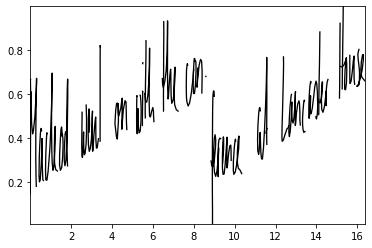

In [51]:
instance = example["gt_list"][0].numpy()
start_points = stroke_recovery.relativefy(instance[:,2])
s = start_points
start_indices = np.argwhere(s==1).astype(int).reshape(-1)
l = np.split(instance[:,0:2], start_indices)

output = []

for item in l:
    if item.shape[0]:
        output.append({"x": item[:,0].tolist(), "y": item[:,1].tolist()})

#print(output)
draw_strokes(output, x_to_y=None)

img = draw_temp(output)
print(img.shape)

In [21]:
path = "./temp"
img = read_img(path)


In [117]:
import dill
dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

print(output)

TypeError: can't pickle ImagingCore objects

In [47]:
## DRAW THE IMAGE
#Pillow-simd

from PIL import Image, ImageDraw

def gt_to_raw(instance):
    start_points = np.array(stroke_recovery.relativefy(instance[:,2]))
    start_indices = np.argwhere(start_points==1).astype(int).reshape(-1)
    l = np.split(instance[:,0:2], start_indices)
    output = []

    for item in l:
        if item.shape[0]:
            output.append({"x": item[:,0].tolist(), "y": item[:,1].tolist()})
    return output

def gt_to_pil_format(instance):
    start_points = stroke_recovery.relativefy(instance[:,2])
    start_indices = np.argwhere(start_points==1).astype(int).reshape(-1)
    l = np.split(instance[:, 0:2], start_indices)
    return l

def get_x_to_y_from_gt(instance):
    x_max = np.max(instance[:,0])
    x_min = np.min(instance[:,0])
    y_min = np.min(instance[:,1])
    y_max = np.max(instance[:,1])    
    print(y_min, y_max, x_min, x_max)
    return (x_max-x_min)/(y_max-y_min)

def get_x_to_y_from_raw(instance):
    y_min = min([min(x["y"]) for x in instance])
    y_max = max([max(x["y"]) for x in instance])
    x_min = min([min(x["x"]) for x in instance])
    x_max = max([max(x["x"]) for x in instance])
    print(y_min, y_max, x_min, x_max)
    return (x_max-x_min)/(y_max-y_min)
    
def draw_from_raw(raw, save_path=None, height=60):
    x_to_y = get_x_to_y_from_raw(raw)   
    width = int(x_to_y * height)
    
    img  = Image.new("L", (width, height), 255)
    draw = ImageDraw.Draw(img)

    for line in raw:
        coords = zip((np.array(line["x"])*height), (np.array(line["y"])*height))
        coords = list(coords)
        draw.line(coords, fill=0, width=1)

    data = np.array(img)[::-1] # invert the y-axis

    img = Image.fromarray(data, 'L')
    if save_path:
        img.save(save_path)
    else:
        img.show()

def draw_from_gt(gt, save_path=None, height=60):
    x_to_y = get_x_to_y_from_gt(gt)   
    width = int(x_to_y * height)
    
    # Rescale the PIL format
    gt_rescaled = gt.copy()
    gt_rescaled[:,0:2] = gt_rescaled[:,0:2] * height
    
    pil_format = gt_to_pil_format(gt_rescaled)     
    img  = Image.new("L", (width, height), 255)
    draw = ImageDraw.Draw(img)
    
    for line in pil_format:
        if line.size:
            line = line.flatten().tolist()
            draw.line(line, fill=0, width=1)
            
    data = np.array(img)[::-1] # invert the y-axis

    img = Image.fromarray(data, 'L')
    if save_path:
        img.save(save_path)
    else:
        img.show()

def loader():
    folder = Path("online_coordinate_data/3_stroke_vSmall")
    folder = Path("online_coordinate_data/8_stroke_vSmall_16")
    folder = Path("online_coordinate_data/MAX_stroke_vTEST_AUGMENTFull")

    print(os.getcwd())
    x_relative_positions = True
    test_size = 5
    train_size = None
    batch_size=32

    test_dataset=StrokeRecoveryDataset([folder / "test_online_coords.json"],
                            img_height = 60,
                            num_of_channels = 1.,
                            max_images_to_load = test_size,
                            root=r"../../data",
                            )

    test_dataloader = DataLoader(test_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  num_workers=3,
                                  collate_fn=test_dataset.collate,
                                  pin_memory=False)

    device="cuda"
    globals().update(locals())
    return test_dataloader

def get_instance():
#     if not 'test_dataloader' in globals():
#         test_dataloader = loader()
    example = next(iter(test_dataloader)) # BATCH, WIDTH, VOCAB
    instance = example["gt_list"][0].numpy()
    return instance, example
def test_drawing():
    instance, example = get_instance()
    
    draw_from_gt(instance)
    draw_from_raw(gt_to_raw(example["gt_list"][0]))

test_drawing()

0.008916861 0.9953917 0.0025406505 5.3824883
0.00891686137765646 0.9953917264938354 0.0025406505446881056 5.382488250732422


In [119]:
print(example.keys())

dict_keys(['line_imgs', 'gt', 'gt_list', 'gt_format', 'label_lengths', 'paths', 'x_func', 'y_func', 'start_times'])


In [168]:
# Test draw
img  = Image.new("L", (50, 60), 255)
draw = ImageDraw.Draw(img)
draw.line([(0,0), (50,50)])
img.show()

In [1]:
warp_points


ImportError: cannot import name 'Image' from 'PIL' (unknown location)

In [20]:
x = np.random.randint(5,10,(10,10))

In [30]:
top = 1
bottom = 4
left = 2
right = 3

np.pad(x, ((top,bottom),(left,right)))


array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 6, 7, 7, 9, 5, 9, 5, 6, 9, 5, 0, 0, 0],
       [0, 0, 6, 8, 5, 8, 5, 8, 6, 8, 7, 7, 0, 0, 0],
       [0, 0, 9, 9, 8, 8, 6, 9, 7, 5, 8, 7, 0, 0, 0],
       [0, 0, 7, 8, 7, 6, 9, 9, 7, 7, 9, 7, 0, 0, 0],
       [0, 0, 6, 5, 8, 8, 7, 5, 9, 9, 6, 9, 0, 0, 0],
       [0, 0, 6, 9, 7, 5, 7, 8, 9, 6, 6, 6, 0, 0, 0],
       [0, 0, 6, 9, 7, 7, 6, 6, 8, 8, 7, 6, 0, 0, 0],
       [0, 0, 5, 7, 6, 8, 5, 6, 9, 6, 6, 7, 0, 0, 0],
       [0, 0, 7, 6, 8, 7, 6, 5, 5, 8, 6, 8, 0, 0, 0],
       [0, 0, 6, 9, 5, 7, 9, 8, 8, 6, 9, 5, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [31]:
y = x[0]+1

In [32]:
print(y)

[ 7  8  8 10  6 10  6  7 10  6]


In [33]:
print(x)

[[6 7 7 9 5 9 5 6 9 5]
 [6 8 5 8 5 8 6 8 7 7]
 [9 9 8 8 6 9 7 5 8 7]
 [7 8 7 6 9 9 7 7 9 7]
 [6 5 8 8 7 5 9 9 6 9]
 [6 9 7 5 7 8 9 6 6 6]
 [6 9 7 7 6 6 8 8 7 6]
 [5 7 6 8 5 6 9 6 6 7]
 [7 6 8 7 6 5 5 8 6 8]
 [6 9 5 7 9 8 8 6 9 5]]


In [100]:
from stroke_plotting import *
instance, example = get_instance()

print(instance.shape)
img = draw_from_gt(instance, show=False)
new_gt, new_img = random_pad(instance, img, 20, 20)

img = Image.fromarray(new_img, 'L')
img.show()
draw_from_gt(new_gt, show=True)


(247, 4)
Top 4
Bottom 4
Right 14
Left 14
0.20535398 5.0190973 0.058672562 0.9413275


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [147]:
#loader()
from stroke_plotting import *
instance, example = get_instance()

print(instance.shape)
get_x_y_min_max_from_gt(instance)
img = draw_from_gt(instance, show=True)
new_gt = random_pad(instance, 15, 15)
draw_from_gt(new_gt, show=True, right_padding="random")


(247, 4)
0.0025406505 5.3824883 0.008916861 0.9953917
0.0025406505 5.3824883 0.008916861 0.9953917


array([[255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       ...,
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)

In [254]:
from hwr_utils.grid_distortion  import *
img = draw_from_gt(instance, show=True)
img = blur(img.copy() / 127.5 - 1.0, max_intensity=1.1)
print(img)
img = (img + 1.0) * 127.5
f = Image.fromarray(np.uint8(img), 'L')
f.show()



[[1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [0.99898241 0.99962966 0.99996103 ... 1.         1.         1.        ]
 ...
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]
 [1.         1.         1.         ... 1.         1.         1.        ]]


In [251]:
from hwr_utils.grid_distortion import *
img = draw_from_gt(instance, show=True)
img = Image.fromarray(img, 'L')
img.show()

if False:
    img = warp_points(instance, random_state=None)
    img = np.c_[img, instance[:,2]]


In [381]:
## DISTORT IMAGE
from hwr_utils.grid_distortion  import *
img_prime = draw_from_gt(instance, show=False, max_width=3)
for i in range(0,1):
    img = img_prime.copy()
    if True:
        img = gaussian_noise(
                blur(
                    random_distortions(img_prime.copy()),
                    max_intensity=1.3),
                max_intensity=.1)
    f = Image.fromarray(np.uint8(img), 'L')
    #f.show()
# Render GT on top of image
f = f.convert("RGB")
img_prime = draw_from_gt(instance, show=False, linewidth=1, color=[255,0,0], alpha=True)
gt = Image.fromarray(np.uint8(img_prime), 'RGBA')
f.paste(gt, (0, 0), gt)
f.show()

#f = Image.fromarray(np.uint8(img), 'L')
    


(array([686.,   0.,   0., 268.,   0.,   0.,  43.,   0.,   0.,   3.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <a list of 10 Patch objects>)

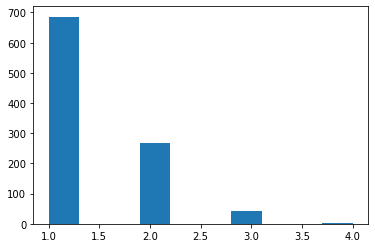

In [288]:
from matplotlib import pyplot as plt
l = []
max_width = 3
for i in range(1000):
    l.append(max(int(abs(np.random.randn())*(max_width-1)*.5 + 1 ),1))

plt.hist(l)

In [332]:
### WARP
from hwr_utils.grid_distortion  import *

for i in range(10):
    gt = instance.copy()
    height = 61
    x = warp_points(gt*height)/height # convert to pixel space
    x = np.c_[x, instance[:,2]]
    img = draw_from_gt(x, show=True, max_width=2, save_path="./warp.png")


In [303]:
m = np.array([[0,2,3,4,5],[0,2,3,4,5]])
m = m.reshape(-1,2)
print(m.shape)
x = warp_points(m)
print(x)

(5, 2)
[[0.         1.5344248 ]
 [3.1491663  3.9160643 ]
 [4.9054227  0.36522734]
 [2.0772712  2.7252445 ]
 [4.2210603  5.106885  ]]


In [333]:
f.show()



In [360]:
im = Image.fromarray(np.uint8(img), 'L')
transparent_area = (0,0,50,50)

mask=Image.new('L', im.size, color=255)
draw=ImageDraw.Draw(mask) 
draw.rectangle(transparent_area, fill=0)
im.putalpha(mask)
im.show()

In [56]:
import pytz
import datetime
MYTIMEZONE = pytz.timezone('US/Mountain')

start_time = datetime.datetime.today().replace(tzinfo=MYTIMEZONE).isoformat()
print(start_time)

2020-01-18T12:17:04.781716-07:00


In [57]:
{'Description': 'https://nhmu.utah.edu/free-days-nhmu\nAlways free:\nUtah Museum of Fine Arts : Free with EBT\nClark Planetarium : Always Free; 110 400 W, Salt Lake City, UT\nHill Aerospace Museum : Always Free; (Ogden) 7961 Wardleigh Rd, Hill AFB, UT 84056\nThanksgiving Point : $2 per person, up to six people, with EBT', 'Subject': 'Natural History Museum of Utah', 'Start Date': '03/03/2020', 'End Date': '03/03/2020', 'Start Time': 0.4166666666666667}

{'Description': 'https://nhmu.utah.edu/free-days-nhmu\nAlways free:\nUtah Museum of Fine Arts : Free with EBT\nClark Planetarium : Always Free; 110 400 W, Salt Lake City, UT\nHill Aerospace Museum : Always Free; (Ogden) 7961 Wardleigh Rd, Hill AFB, UT 84056\nThanksgiving Point : $2 per person, up to six people, with EBT',
 'Subject': 'Natural History Museum of Utah',
 'Start Date': '03/03/2020',
 'End Date': '03/03/2020',
 'Start Time': 0.4166666666666667}

In [61]:
datetime.time(.4*24)

TypeError: integer argument expected, got float

In [60]:
datetime.time(.4)

datetime.time(4, 0)

In [64]:
def time_from_decimal_hrs(hrs):
    hours = int(hrs)
    minutes = int((hrs*60) % 60)
    seconds = int((hrs*3600) % 60)
    return datetime.time(hours, minutes, seconds)
time_from_decimal_hrs(19.4)


19 24 0


datetime.time(19, 24)

In [65]:
datetime.datetime.now().time()

datetime.time(13, 16, 11, 649479)

In [82]:
from pathlib import Path
Path.__add__ = lambda self, rhs: Path(self.parent / "{}{}".format(self.stem,rhs)).with_suffix(self.suffix)

x = Path("/media/my.csv")
x + "raw"


PosixPath('/media/myraw.csv')

In [85]:
from collections import OrderedDict
x = [OrderedDict([('Subject', 'Tracy Aviary'), ('Date', 43501), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Utah Museum of Fine Arts'), ('Date', 'Always'), ('Time', ''), ('Info', 'Free with EBT'), ('Location', '')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 43893), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 43984), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 44075), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 43945), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44036), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44081), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44109), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44170), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44171), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Clark Planetarium'), ('Date', 'Always'), ('Time', ''), ('Info', 'Always Free; 110 400 W, Salt Lake City, UT'), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 43850), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 43939), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44068), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44100), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44146), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Hill Aerospace Museum'), ('Date', 'Always'), ('Time', ''), ('Info', 'Always Free; (Ogden) 7961 Wardleigh Rd, Hill AFB, UT 84056'), ('Location', '')]), OrderedDict([('Subject', 'Scales and Tails'), ('Date', 'Always'), ('Time', ''), ('Info', 'Free with POAP'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44139), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '2600 Sunnyside Ave S, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44146), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '2600 Sunnyside Ave S, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44153), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '2600 Sunnyside Ave S, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44160), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44167), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44174), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44181), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44188), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Thanksgiving Point'), ('Date', 'Always'), ('Time', ''), ('Info', '$2 per person, up to six people, with EBT'), ('Location', '')])]
y = [OrderedDict([('Subject', 'Tracy Aviary'), ('Date', 43501), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Utah Museum of Fine Arts'), ('Date', 'Always'), ('Time', ''), ('Info', 'Free with EBT'), ('Location', '')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 43893), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 43984), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Natural History Museum of Utah (GET TICKETS!)'), ('Date', 44075), ('Time', 0.4166666666666667), ('Info', 'https://nhmu.utah.edu/free-days-nhmu'), ('Location', '301 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 43945), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44036), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44081), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44109), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44170), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Butte Garden'), ('Date', 44171), ('Time', ''), ('Info', ''), ('Location', '300 Wakara Way, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Clark Planetarium'), ('Date', 'Always'), ('Time', ''), ('Info', 'Always Free; 110 400 W, Salt Lake City, UT'), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 43850), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 43939), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44068), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44100), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Free National Parks'), ('Date', 44146), ('Time', ''), ('Info', ''), ('Location', '')]), OrderedDict([('Subject', 'Hill Aerospace Museum'), ('Date', 'Always'), ('Time', ''), ('Info', 'Always Free; (Ogden) 7961 Wardleigh Rd, Hill AFB, UT 84056'), ('Location', '')]), OrderedDict([('Subject', 'Scales and Tails'), ('Date', 'Always'), ('Time', ''), ('Info', 'Free with POAP'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44139), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '2600 Sunnyside Ave S, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44146), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '2600 Sunnyside Ave S, Salt Lake City, UT 84108')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44153), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44160), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44167), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44174), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44181), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Hogle Zoo?'), ('Date', 44188), ('Time', ''), ('Info', 'Unconfirmed'), ('Location', '')]), OrderedDict([('Subject', 'Thanksgiving Point'), ('Date', 'Always'), ('Time', ''), ('Info', '$2 per person, up to six people, with EBT'), ('Location', '')])]

def different_from_old(line, old_calendar):
    return old_calendar and all(line != old_line for old_line in old_calendar)

different_from_old(x[0], y)

False